In [148]:
from collections import namedtuple
import random
from copy import deepcopy
from itertools import accumulate
from operator import xor
import matplotlib.pyplot as plt

## The *Nim* and *Nimply* classes

In [149]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [150]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        self._rows[row] -= num_objects   
    
    def adding(self, ply: Nimply) -> None:
        row, num_objects = ply
        self._rows[row] += num_objects

In [151]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result


def cook_status(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)
    ]
    cooked["active_rows_number"] = sum(o > 0 for o in state.rows)
    cooked["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    cooked["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    cooked["nim_sum"] = nim_sum(state)

    brute_force = list()
    for m in cooked["possible_moves"]:
        tmp = deepcopy(state)
        tmp.nimming(m)
        brute_force.append((m, nim_sum(tmp)))
    cooked["brute_force"] = brute_force

    return cooked

# for the recursive function, to save a bit the computational cost, because compute only the possible moves 
# removing only one object (instead of use "cook_status(state: Nim) -> dict:")
def cook_status_for_rec(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_remove_one"]= [
        (r, 1) for r, c  in enumerate(state.rows) if c > 0
    ]
    return cooked


In [152]:
NIM_SIZE= 5

### Find all possible states from a state

In [153]:
def all_possible_states(res: set, state: Nim):
    recursive_search(state, res)
    #adding the tuple (0,0,0,0,0) (eg if NIM_SIZE=5)
    all_zero= []   
    for _ in range(NIM_SIZE):
        all_zero.append(0)
    res.add(tuple(all_zero))
    return res #this set contains all the possible states, for instance, for NIM_SIZE=5, from (1,3,5,7,9) to (0,0,0,0,0)

def recursive_search(state: Nim, result: set):
    if state.rows  not in result: #enter only if the state is not already in the set
        data= cook_status_for_rec(state)
        result.add(state.rows)
        for p in data["possible_remove_one"]:
            state.nimming(p)
            if(state): #if it is not all zeros, do the recursive call
                recursive_search(state, result)
            if list(data["possible_remove_one"]) != []: #if not all the considered plys from the current state are done
                #add again the object removed by the ply to the state and remove the ply from the possible moves
                state.adding(p)
                temp= list(data["possible_remove_one"])
                temp.remove(p)
                data["possible_remove_one"]= temp



### Random Agent

In [154]:
def pure_random(state: Nim) -> Nimply:
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

### Optimal (Nim-Sum) Agent

In [155]:
def optimal_strategy(state: Nim) -> Nimply:
    data = cook_status(state)
    return next((bf for bf in data["brute_force"] if bf[1] == 0), random.choice(data["brute_force"]))[0]

## Reinforcement Learning Agent

In [156]:
class Agent(object):
    def __init__(self, states, alpha=0.15, random_factor=0.2):  # 80% explore, 20% exploit
        self.state_history = []  # state, reward
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(states)

    def init_reward(self, states):
        for st in states:
            self.G[st] = random.uniform(0, 5*NIM_SIZE/3) # 5*NIM_SIZE/3 is an hyperparameter

    def choose_action(self, state:Nim):
        allowedMoves= [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
        minG = 10e15
        next_move = None
        if random.random() < self.random_factor:
            # if random number below random factor, choose random action
            next_move = random.choice(allowedMoves)
        else:
            # if exploiting, gather all possible actions and choose one with the highest G (reward)
            for action in allowedMoves:
                state.nimming(action) # do a nim
                if self.G[state.rows] <= minG: # verify if the G is better than the best so far
                    next_move = action
                    minG = self.G[state.rows]
                state.adding(action)  # add again the objects removed from the nimmings
        return next_move  #return the ply

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

    def learn(self):
        target = 0
        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward
        self.state_history = []
        self.random_factor -= 10e-5  # decrease random factor each episode of play


### "Main"

[1, 78, 77, 86, 85, 82, 83, 90, 97, 93, 85, 90, 90, 90, 91, 87, 87, 90, 89, 99, 97, 95, 93, 99, 98, 97, 95, 97, 92, 97, 93, 96, 95, 96, 94, 91, 95, 96, 97, 94, 99, 94, 94, 96, 95, 99, 98, 95, 96, 96, 92, 99, 97, 96, 95, 97, 100, 97, 99, 92, 94, 97, 95, 97, 97, 93, 99, 95, 97, 97, 95, 97, 93, 94, 95, 93, 94, 92, 93, 92, 97, 94, 95, 98, 97, 94, 94, 96, 93, 95, 94, 96, 99, 99, 95, 98, 94, 96, 96, 97]


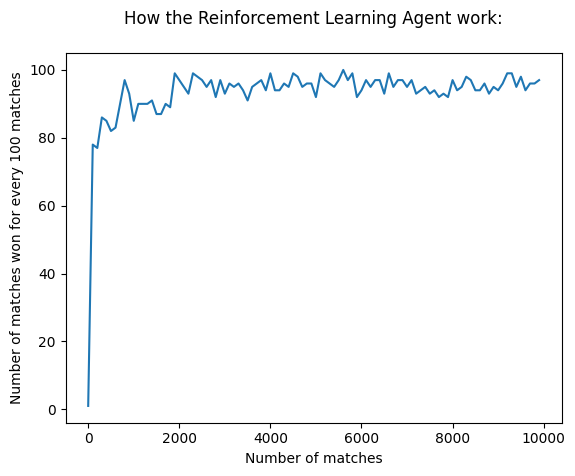

In [157]:
res= set() 
robot = Agent(all_possible_states(res, Nim(NIM_SIZE)))
winsHistory = []
indices = []
p1_wins=0

for m in range(10000):
    x= Nim(NIM_SIZE)
    if m%2== 0: #one time it starts first, one time second
        p1_turn= True
    else:
        p1_turn= False
    while(x):
        if(p1_turn):
            ply = robot.choose_action(x)
            x.nimming(ply)
            reward = nim_sum(x)
            robot.update_state_history(x.rows, reward)           
            p1_turn= False
        else:
            ply= pure_random(x)
            x.nimming(ply)
            p1_turn= True
    if(not p1_turn):
        robot.learn() #it learns ONLY if it wins
        p1_wins+=1
    if m % 100 == 0:
        winsHistory.append(p1_wins)
        indices.append(m)
        p1_wins=0
       
print(winsHistory)
plt.plot(indices, winsHistory)
plt.xlabel('Number of matches')
plt.ylabel('Number of matches won for every 100 matches')
plt.title('How the Reinforcement Learning Agent work:\n')
plt.show()
    